# CWRU Bearing Fault Diagnosis with Spectrogram and Scalogram Inputs

This notebook implements a Convolutional Neural Network (CNN) for fault diagnosis of rolling element bearings using the Case Western Reserve University (CWRU) dataset. The methodology is based on Verstraete et al. (2017), which uses time-frequency image representations (spectrograms via STFT and scalograms via Morlet wavelet transform) as inputs to a CNN. The CNN architecture features double convolutional layers before pooling to enhance feature expressivity.


## Overview
- **Dataset**: CWRU Bearing Data (2HP load, various fault types and sizes)
- **Input**: 96x96 pixel spectrogram or scalogram images
- **Model**: CNN with three stages of double conv layers (32, 64, 128 filters), max pooling, and two dense layers
- **Training**: 5-fold stratified cross-validation with early stopping
- **Evaluation**: Accuracy, confusion matrices, precision, recall, F1 score

## Requirements
- Python libraries: tensorflow, numpy, scipy, scikit-learn, matplotlib, seaborn, pywt, skimage
- CWRU dataset files in 'CWRU_BearingData_Load_2HP' folder

Run cells sequentially to load data, preprocess, train the model, and evaluate results.

In [1]:
# Setup for Reproducibility
import tensorflow as tf
import numpy as np
import random
import os

# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Import additional libraries
import scipy.io
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from skimage.transform import resize
import pywt  # For wavelet transform

## Load CWRU Bearing Data

The `ImportData` function loads the CWRU dataset files (.mat) containing vibration signals for normal and fault conditions (inner race, ball, outer race) at various fault sizes under a 2HP load. The data is stored in a list for further processing.

In [2]:
def ImportData():
    folder_path = 'CWRU_BearingData_Load_2HP'
    file_paths = [
        os.path.join(folder_path, '99.mat'),
        os.path.join(folder_path, '111.mat'),
        os.path.join(folder_path, '124.mat'),
        os.path.join(folder_path, '137.mat'),
        os.path.join(folder_path, '176.mat'),
        os.path.join(folder_path, '191.mat'),
        os.path.join(folder_path, '203.mat'),
        os.path.join(folder_path, '215.mat'),
        os.path.join(folder_path, '228.mat'),
        os.path.join(folder_path, '240.mat')
    ]
    data_keys = [
        'X099_DE_time', 'X111_DE_time', 'X124_DE_time', 'X137_DE_time',
        'X176_DE_time', 'X191_DE_time', 'X203_DE_time', 'X215_DE_time',
        'X228_DE_time', 'X240_DE_time'
    ]
    data = [scipy.io.loadmat(fp)[key] for fp, key in zip(file_paths, data_keys)]
    return data

## Time-Frequency Image Generation

The following functions generate spectrogram and scalogram images from vibration signal segments, as per Verstraete et al. (2017):
- **Spectrogram**: Uses Short-Time Fourier Transform (STFT) with a Hann window, 256-point segments, and 128-point overlap. Images are normalized and resized to 96x96 pixels.
- **Scalogram**: Uses Continuous Wavelet Transform (CWT) with the Morlet wavelet, scales 1 to 128. Magnitude is normalized and resized to 96x96 pixels.

In [ ]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape=(96, 96)):
    """
    Calculate the spectrogram of an array data_y_vector and resize it to image_shape.
    """
    fs = 48000
    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs,
        nperseg=256,
        # noverlap=128,
        window='hann'
    )
    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)
    return sxx

def generate_scalogram_image(data_y_vector, image_shape=(96, 96)):
    """
    Calculate the scalogram using Morlet wavelet and resize it to image_shape.
    """
    fs = 48000
    scales = np.arange(1, 128)  # Adjust scales for Morlet wavelet
    coef, freqs = pywt.cwt(
        data_y_vector,
        scales,
        'morl',
        sampling_period=1/fs
    )
    coef = np.abs(coef)  # Use magnitude
    coef = min_max_norm(coef)
    coef = resize(coef, image_shape, mode='constant', anti_aliasing=True)
    return coef

## Data Preprocessing

The `Sampling` function segments the vibration signals into blocks, and `DataPreparation` generates spectrogram or scalogram images for each segment. Labels are created in one-hot encoded format (`Y_CNN`) for CNN training and as integers (`Y`) for stratification. The output is a 4D array of images and corresponding labels.

In [4]:
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T
    return SplitData

def DataPreparation(Data, interval_length, samples_per_block, image_type='spectrogram'):
    """
    Prepare data by generating spectrogram or scalogram images.
    """
    X = []
    LabelPositional = []
    Label = []
    for count, data in enumerate(Data):
        SplitData = Sampling(data, interval_length, samples_per_block)
        images = []
        for segment in SplitData:
            if image_type == 'spectrogram':
                img = generate_spectrogram_image(segment)
            elif image_type == 'scalogram':
                img = generate_scalogram_image(segment)
            images.append(img)
        images = np.array(images)
        y = np.zeros([len(SplitData), 10])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        X.append(images)
        LabelPositional.append(y)
        Label.append(y1)
    X = np.concatenate(X, axis=0)
    LabelPositional = np.concatenate(LabelPositional, axis=0)
    Label = np.concatenate(Label, axis=0)
    return X, LabelPositional, Label

## CNN Model Definition

The `CNN_2D` class defines the CNN architecture as per Verstraete et al. (2017):
- Three stages, each with two convolutional layers (32, 64, 128 filters, 3x3 kernels) followed by 2x2 max pooling.
- Two dense layers (100 units each) with dropout (0.5) before the second dense layer.
- Output layer with 10 units (softmax) for 10-class classification.
- Compiled with Adam optimizer and categorical crossentropy loss.

In [5]:
class CNN_2D():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 1)),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(96, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

## Main Execution

This section executes the pipeline:
- Loads and preprocesses data to generate 96x96 images (spectrogram or scalogram).
- Splits data into training (80%) and test (20%) sets with stratification.
- Performs 5-fold cross-validation with early stopping and model checkpointing.
- Saves the best model for each fold.

**Parameters**:
- `image_type`: Set to 'scalogram' or 'spectrogram' to choose input type.
- `image_shape`: 96x96 pixels for high accuracy (per Verstraete et al.).
- `kSplits`: 5 for cross-validation.
- `foldername`: Directory to save model checkpoints.

In [8]:
# Parameters
interval_length = 1600
samples_per_block = 1600
image_type = 'scalogram'  # Change to 'spectrogram' to use spectrograms
image_shape = (96, 96)
kSplits = 5
foldername = "CNN2D_results/ScalogramHP2-96x96/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

# Load and prepare data
Data = ImportData()
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block, image_type=image_type)
Input_2D = X.reshape([-1, image_shape[0], image_shape[1], 1])
print(f"Shape of Input Data: {Input_2D.shape}")

# Train-test split
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(
    Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y
)


Shape of Input Data: (3026, 96, 96, 1)


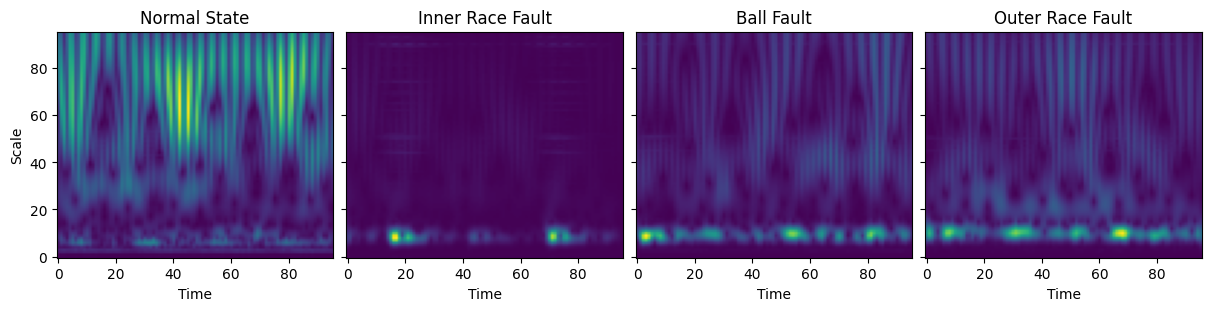

In [10]:
# Create a figure with four subplots, sharing the y-axis
fig, (plt1, plt2, plt3, plt4) = plt.subplots(1, 4, sharey=True, figsize=(12, 3), constrained_layout=True)

# Plot Normal state spectrogram (index 0, assuming Normal samples are at the start)
plt1.set_xlabel("Time")
plt1.set_ylabel("Scale")
plt1.set_title('Normal State')
plt1.imshow(Input_2D[0, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Inner Race fault spectrogram (index 1000, assuming Inner Race samples around this index)
plt2.set_xlabel("Time")
plt2.set_title('Inner Race Fault')
plt2.imshow(Input_2D[1000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Ball fault spectrogram (index 2000, assuming Ball fault samples around this index)
plt3.set_xlabel("Time")
plt3.set_title('Ball Fault')
plt3.imshow(Input_2D[2000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Outer Race fault spectrogram (index 2500, assuming Outer Race samples around this index)
plt4.set_xlabel("Time")
plt4.set_title('Outer Race Fault')
plt4.imshow(Input_2D[2500, :, :], aspect='auto', origin='lower', cmap='viridis')

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
# K-fold cross-validation
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True)
accuracy_train = []
accuracy_val = []
accuracy_test = []
precision_val = []
recall_val = []
f1_val = []
pred_all_val = np.zeros([len(X_2D_train), 10])
y_2D_val = np.zeros([len(X_2D_train), 10])
kfold_test_len = []
fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Train the model
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):
    checkpoint_filepath = foldername + f"best_model_{k}.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    Classification_2D = CNN_2D()
    history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )
    print(f"Best model saved at: {checkpoint_filepath}")
    CNN_2D_best_model = load_model(checkpoint_filepath)
    print("Best model loaded successfully!")
    
    fl2 = fl1 + len(test)
    pred_all_val[fl1:fl2, :] = CNN_2D_best_model.predict(X_2D_train[test])
    y_2D_val[fl1:fl2, :] = y_2D_train[test]
    kfold_test_len.append(fl2 - fl1)
    fl1 = fl2

    train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train])
    accuracy_train.append(train_accuracy)
    val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test])
    accuracy_val.append(val_accuracy)
    test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test)
    accuracy_test.append(test_accuracy)


    # Calculate precision, recall, and F1 score for validation set
    y_pred_val = np.argmax(CNN_2D_best_model.predict(X_2D_train[test]), axis=1)
    y_true_val = np.argmax(y_2D_train[test], axis=1)
    precision_val.append(precision_score(y_true_val, y_pred_val, average='weighted'))
    recall_val.append(recall_score(y_true_val, y_pred_val, average='weighted'))
    f1_val.append(f1_score(y_true_val, y_pred_val, average='weighted'))
    
    k += 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 11:29:58.534961: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 11:29:58.537200: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2794 - loss: 1.8876

2025-06-17 11:31:38.953609: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 11:31:38.954409: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.72107, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2818 - loss: 1.8818 - val_accuracy: 0.7211 - val_loss: 0.6538
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7184 - loss: 0.8119
Epoch 2: val_accuracy improved from 0.72107 to 0.88636, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7192 - loss: 0.8098 - val_accuracy: 0.8864 - val_loss: 0.3024
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8375 - loss: 0.4460
Epoch 3: val_accuracy improved from 0.88636 to 0.93802, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8377 - loss: 0.4455 - val_accuracy: 0.9380 - val_loss: 0.1592
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8635 - loss: 0.3818
Epoch 4: val_accuracy improved from 0.93802 to 0.97727, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8637 - loss: 0.3816 - val_accuracy: 0.9773 - val_loss: 0.1081
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8963 - loss: 0.2741
Epoch 5: val_accuracy did not improve from 0.97727
61/61 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8964 - loss: 0.2739 - val_accuracy: 0.9607 - val_loss: 0.1223
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8951 - loss: 0.2647
Epoch 6: val_accuracy improved from 0.97727 to 0.97934, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8953 - loss: 0.2643 - val_accuracy: 0.9793 - val_loss: 0.0534
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9061 - loss: 0.2433
Epoch 7: val_accuracy improved from 0.97934 to 0.98140, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9065 - loss: 0.2426 - val_accuracy: 0.9814 - val_loss: 0.0631
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9377 - loss: 0.1853
Epoch 8: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9378 - loss: 0.1847 - val_accuracy: 0.9814 - val_loss: 0.0547
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9415 - loss: 0.1598
Epoch 9: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9415 - loss: 0.1600 - val_accuracy: 0.9380 - val_loss: 0.1523
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9392 - loss: 0.1638
Epoch 10: val_accuracy improved from 0.98140 to 0.99174, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9391 - loss: 0.1639 - val_accuracy: 0.9917 - val_loss: 0.0266
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9551 - loss: 0.1403
Epoch 11: val_accuracy did not improve from 0.99174
61/61 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9551 - loss: 0.1404 - val_accuracy: 0.9876 - val_loss: 0.0403
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9452 - loss: 0.1432
Epoch 12: val_accuracy did not improve from 0.99174
61/61 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9453 - loss: 0.1430 - val_accuracy: 0.9855 - val_loss: 0.0338
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9592 - loss: 0.1210
Epoch 13: val_accuracy did not improve from 0.99174
61/61 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9591 - loss: 0.1211 - val_accuracy: 0.9876 - val_loss: 0.0494
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9574 - loss: 0.1085
Epoch 14: val_accuracy did not improve fro

61/61 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9762 - loss: 0.0616 - val_accuracy: 0.9938 - val_loss: 0.0240
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9779 - loss: 0.0553
Epoch 28: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9779 - loss: 0.0553 - val_accuracy: 0.9690 - val_loss: 0.0925
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9790 - loss: 0.0530
Epoch 29: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9790 - loss: 0.0530 - val_accuracy: 0.9855 - val_loss: 0.0410
Epoch 30/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9826 - loss: 0.0609
Epoch 30: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9827 - loss: 0.0608 - val_accuracy: 0.9876 - val_loss: 0.0483
Epoch 31/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9881 - loss: 0.0369
Epoch 31: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 13:53:11.349423: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 13:53:11.356077: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step


2025-06-17 13:53:18.374341: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 13:53:18.374710: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.9994 - loss: 0.0041


2025-06-17 13:53:43.582171: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 13:53:43.582533: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - accuracy: 0.9941 - loss: 0.0253


2025-06-17 13:53:49.841828: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 13:53:49.842165: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step - accuracy: 0.9885 - loss: 0.0321


2025-06-17 13:53:57.491804: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 13:53:57.492090: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step
Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-17 13:54:03.902664: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2754 - loss: 1.9505

2025-06-17 13:55:25.641640: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 13:55:25.642014: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.84504, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.2779 - loss: 1.9437 - val_accuracy: 0.8450 - val_loss: 0.4104
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7630 - loss: 0.6660
Epoch 2: val_accuracy improved from 0.84504 to 0.94628, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7636 - loss: 0.6637 - val_accuracy: 0.9463 - val_loss: 0.1518
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8503 - loss: 0.4077
Epoch 3: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8503 - loss: 0.4074 - val_accuracy: 0.9277 - val_loss: 0.2148
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8769 - loss: 0.3256
Epoch 4: val_accuracy improved from 0.94628 to 0.96901, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8772 - loss: 0.3253 - val_accuracy: 0.9690 - val_loss: 0.0898
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8920 - loss: 0.2985
Epoch 5: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8922 - loss: 0.2979 - val_accuracy: 0.9669 - val_loss: 0.0826
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9281 - loss: 0.2065
Epoch 6: val_accuracy improved from 0.96901 to 0.98554, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9280 - loss: 0.2065 - val_accuracy: 0.9855 - val_loss: 0.0513
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9347 - loss: 0.1692
Epoch 7: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9348 - loss: 0.1690 - val_accuracy: 0.9773 - val_loss: 0.0555
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9319 - loss: 0.1817
Epoch 8: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9320 - loss: 0.1815 - val_accuracy: 0.9731 - val_loss: 0.0819
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9488 - loss: 0.1469
Epoch 9: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9489 - loss: 0.1467 - val_accuracy: 0.9649 - val_loss: 0.1126
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9474 - loss: 0.1337
Epoch 10: val_accuracy did not improve from 0.9855

61/61 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9719 - loss: 0.0559 - val_accuracy: 0.9897 - val_loss: 0.0524
Epoch 33/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9778 - loss: 0.0495
Epoch 33: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9779 - loss: 0.0494 - val_accuracy: 0.9814 - val_loss: 0.0920
Epoch 34/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9876 - loss: 0.0368
Epoch 34: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9875 - loss: 0.0370 - val_accuracy: 0.9855 - val_loss: 0.0678
Epoch 35/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9777 - loss: 0.0563
Epoch 35: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9778 - loss: 0.0561 - val_accuracy: 0.9814 - val_loss: 0.1034
Epoch 36/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9738 - loss: 0.0615
Epoch 36: val_accuracy did not improve from

Best model loaded successfully!


2025-06-17 16:05:45.402970: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:05:45.404204: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step


2025-06-17 16:05:54.465297: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:05:54.465669: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 417ms/step - accuracy: 0.9993 - loss: 0.0033


2025-06-17 16:06:20.504189: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:06:20.504545: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.9883 - loss: 0.0690


2025-06-17 16:06:27.181136: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:06:27.181572: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.9915 - loss: 0.0369


2025-06-17 16:06:35.102183: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:06:35.102625: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 402ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 16:06:41.948675: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:06:41.949024: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2925 - loss: 1.9320

2025-06-17 16:08:09.984381: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:08:09.984781: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.79752, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2946 - loss: 1.9261 - val_accuracy: 0.7975 - val_loss: 0.6858
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7449 - loss: 0.7181
Epoch 2: val_accuracy improved from 0.79752 to 0.94215, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7452 - loss: 0.7170 - val_accuracy: 0.9421 - val_loss: 0.1899
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8272 - loss: 0.4632
Epoch 3: val_accuracy improved from 0.94215 to 0.96694, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8275 - loss: 0.4625 - val_accuracy: 0.9669 - val_loss: 0.1303
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8725 - loss: 0.3222
Epoch 4: val_accuracy improved from 0.96694 to 0.97521, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8725 - loss: 0.3222 - val_accuracy: 0.9752 - val_loss: 0.0988
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8793 - loss: 0.3192
Epoch 5: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8793 - loss: 0.3194 - val_accuracy: 0.9607 - val_loss: 0.1020
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8854 - loss: 0.2988
Epoch 6: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8853 - loss: 0.2985 - val_accuracy: 0.9711 - val_loss: 0.1024
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8938 - loss: 0.2465
Epoch 7: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8939 - loss: 0.2464 - val_accuracy: 0.9545 - val_loss: 0.1701
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8857 - loss: 0.3225
Epoch 8: val_accuracy improved from 0.97521 to 0.9

61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8859 - loss: 0.3221 - val_accuracy: 0.9814 - val_loss: 0.0819
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9246 - loss: 0.2156
Epoch 9: val_accuracy improved from 0.98140 to 0.98554, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9246 - loss: 0.2156 - val_accuracy: 0.9855 - val_loss: 0.0536
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9227 - loss: 0.2147
Epoch 10: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9226 - loss: 0.2148 - val_accuracy: 0.9855 - val_loss: 0.0381
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9481 - loss: 0.1529
Epoch 11: val_accuracy improved from 0.98554 to 0.99380, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9481 - loss: 0.1530 - val_accuracy: 0.9938 - val_loss: 0.0179
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9451 - loss: 0.1566
Epoch 12: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9449 - loss: 0.1568 - val_accuracy: 0.9773 - val_loss: 0.0797
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9400 - loss: 0.1582
Epoch 13: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9399 - loss: 0.1583 - val_accuracy: 0.9731 - val_loss: 0.0582
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9362 - loss: 0.1747
Epoch 14: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9363 - loss: 0.1745 - val_accuracy: 0.9731 - val_loss: 0.0793
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9520 - loss: 0.1212
Epoch 15: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9666 - loss: 0.1161 - val_accuracy: 0.9979 - val_loss: 0.0140
Epoch 17/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9562 - loss: 0.1176
Epoch 17: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9561 - loss: 0.1179 - val_accuracy: 0.9855 - val_loss: 0.0422
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9600 - loss: 0.1197
Epoch 18: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9600 - loss: 0.1197 - val_accuracy: 0.9917 - val_loss: 0.0247
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9692 - loss: 0.0885
Epoch 19: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9691 - loss: 0.0889 - val_accuracy: 0.9752 - val_loss: 0.0683
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9439 - loss: 0.1404
Epoch 20: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 17:47:07.559326: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 17:47:07.560355: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 402ms/step


2025-06-17 17:47:14.844723: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 17:47:14.845115: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 428ms/step - accuracy: 0.9949 - loss: 0.0155


2025-06-17 17:47:41.268728: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 17:47:41.269063: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.9970 - loss: 0.0172


2025-06-17 17:47:47.745557: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 17:47:47.745896: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 422ms/step - accuracy: 0.9903 - loss: 0.0256


2025-06-17 17:47:55.883200: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 17:47:55.883594: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 17:48:03.770188: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 17:48:03.770594: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2871 - loss: 1.9679

2025-06-17 17:49:33.153673: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 17:49:33.154626: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.76860, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.2893 - loss: 1.9618 - val_accuracy: 0.7686 - val_loss: 0.5656
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6866 - loss: 0.8811
Epoch 2: val_accuracy improved from 0.76860 to 0.95041, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.6876 - loss: 0.8783 - val_accuracy: 0.9504 - val_loss: 0.2048
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8412 - loss: 0.4257
Epoch 3: val_accuracy did not improve from 0.95041
61/61 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8413 - loss: 0.4254 - val_accuracy: 0.8864 - val_loss: 0.3431
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8913 - loss: 0.3011
Epoch 4: val_accuracy did not improve from 0.95041
61/61 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8916 - loss: 0.3006 - val_accuracy: 0.9112 - val_loss: 0.1608
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9019 - loss: 0.2674
Epoch 5: val_accuracy improved from 0.95041 to 0.97727, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9020 - loss: 0.2673 - val_accuracy: 0.9773 - val_loss: 0.0865
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9442 - loss: 0.1671
Epoch 6: val_accuracy did not improve from 0.97727
61/61 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9441 - loss: 0.1673 - val_accuracy: 0.9649 - val_loss: 0.0704
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9345 - loss: 0.1915
Epoch 7: val_accuracy did not improve from 0.97727
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9345 - loss: 0.1916 - val_accuracy: 0.9669 - val_loss: 0.0963
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9408 - loss: 0.1702
Epoch 8: val_accuracy did not improve from 0.97727
61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9409 - loss: 0.1699 - val_accuracy: 0.9545 - val_loss: 0.1024
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9556 - loss: 0.1238
Epoch 9: val_accuracy did not improve from 0.97727


61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9582 - loss: 0.1103 - val_accuracy: 0.9793 - val_loss: 0.0672
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9698 - loss: 0.0774
Epoch 16: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9698 - loss: 0.0776 - val_accuracy: 0.9566 - val_loss: 0.1211
Epoch 17/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9631 - loss: 0.0907
Epoch 17: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9631 - loss: 0.0908 - val_accuracy: 0.9421 - val_loss: 0.1662
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9571 - loss: 0.1304
Epoch 18: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9571 - loss: 0.1302 - val_accuracy: 0.9669 - val_loss: 0.1110
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9718 - loss: 0.0780
Epoch 19: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9770 - loss: 0.0662 - val_accuracy: 0.9814 - val_loss: 0.0500
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9842 - loss: 0.0454
Epoch 26: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9841 - loss: 0.0454 - val_accuracy: 0.9731 - val_loss: 0.0748
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9794 - loss: 0.0567
Epoch 27: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9794 - loss: 0.0567 - val_accuracy: 0.9731 - val_loss: 0.0931
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9678 - loss: 0.0966
Epoch 28: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9678 - loss: 0.0969 - val_accuracy: 0.9731 - val_loss: 0.0747
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9796 - loss: 0.0567
Epoch 29: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9651 - loss: 0.1026 - val_accuracy: 0.9855 - val_loss: 0.0638
Epoch 32/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9844 - loss: 0.0523
Epoch 32: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9843 - loss: 0.0525 - val_accuracy: 0.9628 - val_loss: 0.1495
Epoch 33/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9783 - loss: 0.0652
Epoch 33: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9783 - loss: 0.0651 - val_accuracy: 0.9504 - val_loss: 0.1937
Epoch 34/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9804 - loss: 0.0533
Epoch 34: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9804 - loss: 0.0533 - val_accuracy: 0.9773 - val_loss: 0.1282
Epoch 35/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9859 - loss: 0.0458
Epoch 35: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9884 - loss: 0.0321 - val_accuracy: 0.9897 - val_loss: 0.0758
Epoch 64/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9822 - loss: 0.0539
Epoch 64: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9823 - loss: 0.0537 - val_accuracy: 0.9835 - val_loss: 0.0615
Epoch 65/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9916 - loss: 0.0274
Epoch 65: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9915 - loss: 0.0274 - val_accuracy: 0.9731 - val_loss: 0.0788
Epoch 66/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9923 - loss: 0.0232
Epoch 66: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9923 - loss: 0.0232 - val_accuracy: 0.9690 - val_loss: 0.1848
Epoch 67/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9863 - loss: 0.0374
Epoch 67: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 20:51:54.004011: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 20:51:54.004502: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step


2025-06-17 20:52:00.838817: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:52:00.839124: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 391ms/step - accuracy: 1.0000 - loss: 5.7075e-05


2025-06-17 20:52:25.081592: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:52:25.081894: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.9843 - loss: 0.0964


2025-06-17 20:52:31.324652: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:52:31.324990: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - accuracy: 0.9870 - loss: 0.0390


2025-06-17 20:52:40.034142: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 20:52:40.034459: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 20:52:46.353434: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:52:46.353882: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2725 - loss: 1.9863

2025-06-17 20:54:13.827525: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 20:54:13.828035: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.78926, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2747 - loss: 1.9804 - val_accuracy: 0.7893 - val_loss: 0.6302
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7217 - loss: 0.7514
Epoch 2: val_accuracy improved from 0.78926 to 0.91736, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.7224 - loss: 0.7497 - val_accuracy: 0.9174 - val_loss: 0.2320
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8325 - loss: 0.4402
Epoch 3: val_accuracy improved from 0.91736 to 0.97314, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8327 - loss: 0.4402 - val_accuracy: 0.9731 - val_loss: 0.1501
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8771 - loss: 0.3047
Epoch 4: val_accuracy did not improve from 0.97314
61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8771 - loss: 0.3048 - val_accuracy: 0.9463 - val_loss: 0.1964
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8888 - loss: 0.2915
Epoch 5: val_accuracy improved from 0.97314 to 0.98760, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8890 - loss: 0.2909 - val_accuracy: 0.9876 - val_loss: 0.0796
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9396 - loss: 0.1811 
Epoch 6: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 1092s 18s/step - accuracy: 0.9394 - loss: 0.1812 - val_accuracy: 0.9690 - val_loss: 0.1132
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9228 - loss: 0.2112
Epoch 7: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9229 - loss: 0.2111 - val_accuracy: 0.9607 - val_loss: 0.1011
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9239 - loss: 0.2196
Epoch 8: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 402s 7s/step - accuracy: 0.9240 - loss: 0.2194 - val_accuracy: 0.9669 - val_loss: 0.1497
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8948 - loss: 0.2618
Epoch 9: val_accuracy did not improve from 0.

61/61 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9490 - loss: 0.1498 - val_accuracy: 0.9897 - val_loss: 0.0564
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9558 - loss: 0.1226
Epoch 13: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9557 - loss: 0.1227 - val_accuracy: 0.9897 - val_loss: 0.0473
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9621 - loss: 0.0963
Epoch 14: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9621 - loss: 0.0964 - val_accuracy: 0.9876 - val_loss: 0.0616
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9625 - loss: 0.0969
Epoch 15: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9624 - loss: 0.0971 - val_accuracy: 0.9876 - val_loss: 0.0555
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9639 - loss: 0.1048
Epoch 16: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9530 - loss: 0.1112 - val_accuracy: 0.9938 - val_loss: 0.0347
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9625 - loss: 0.0856
Epoch 18: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9623 - loss: 0.0861 - val_accuracy: 0.9876 - val_loss: 0.0567
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9510 - loss: 0.1132
Epoch 19: val_accuracy improved from 0.99380 to 0.99587, saving model to CNN2D_results/ScalogramHP2-96x96/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9511 - loss: 0.1131 - val_accuracy: 0.9959 - val_loss: 0.0198
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9647 - loss: 0.1181
Epoch 20: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9647 - loss: 0.1181 - val_accuracy: 0.9917 - val_loss: 0.0266
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9757 - loss: 0.0759
Epoch 21: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9757 - loss: 0.0759 - val_accuracy: 0.9959 - val_loss: 0.0275
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9647 - loss: 0.0931
Epoch 22: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9645 - loss: 0.0936 - val_accuracy: 0.9855 - val_loss: 0.0453
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9714 - loss: 0.0767
Epoch 23: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9819 - loss: 0.0506 - val_accuracy: 0.9979 - val_loss: 0.0166
Epoch 48/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9755 - loss: 0.0665
Epoch 48: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9754 - loss: 0.0669 - val_accuracy: 0.9814 - val_loss: 0.0560
Epoch 49/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9663 - loss: 0.0835
Epoch 49: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9664 - loss: 0.0836 - val_accuracy: 0.9835 - val_loss: 0.0477
Epoch 50/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9612 - loss: 0.1019
Epoch 50: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9613 - loss: 0.1017 - val_accuracy: 0.9938 - val_loss: 0.0378
Epoch 51/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9847 - loss: 0.0394
Epoch 51: val_accuracy did not improve from

Best model loaded successfully!


2025-06-18 00:08:52.225185: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 00:08:52.226008: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step


2025-06-18 00:08:58.883119: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 00:08:58.883454: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 394ms/step - accuracy: 1.0000 - loss: 2.4949e-04


2025-06-18 00:09:25.921913: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 00:09:25.922229: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.9995 - loss: 0.0054


2025-06-18 00:09:32.244063: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-18 00:09:32.244367: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accuracy: 0.9934 - loss: 0.0232


2025-06-18 00:09:39.935667: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-18 00:09:39.935955: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step


## Model Evaluation

Evaluate the trained model by computing average accuracies across folds for training, validation, and test sets. Visualize performance with confusion matrices for train and test sets, and bar plots for fold-wise and train vs. test accuracies.

CNN 2D train accuracy = 99.83471035957336
CNN 2D validation accuracy = 99.38016533851624
CNN 2D test accuracy = 99.07590627670288


2025-06-19 09:05:08.749445: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-19 09:05:08.750683: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 386ms/step


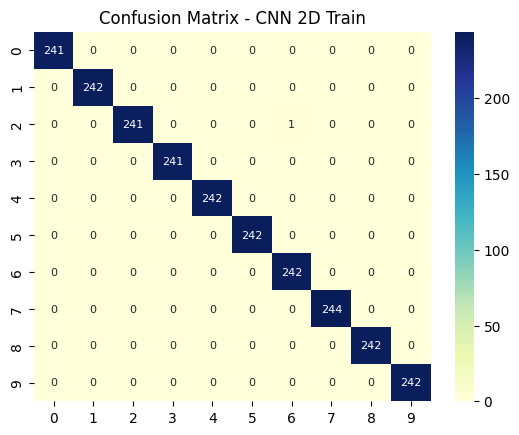

2025-06-19 09:05:38.697088: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-19 09:05:38.697604: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step


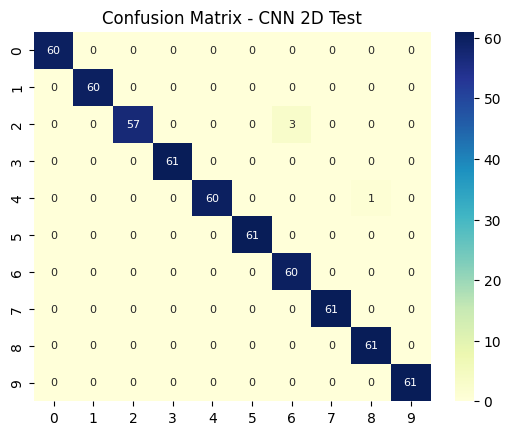

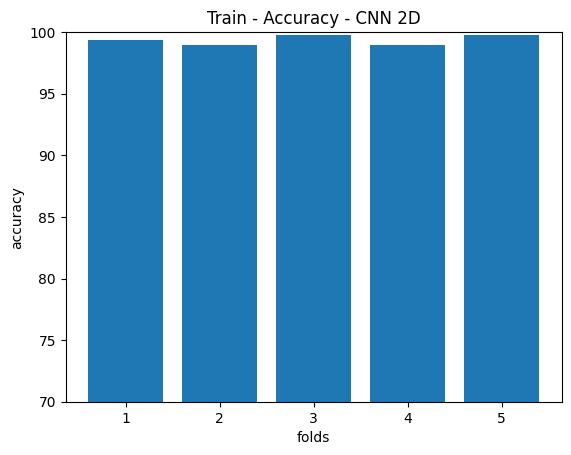

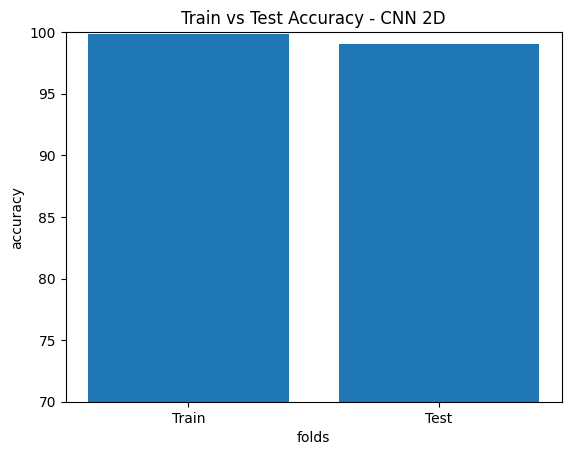

In [13]:
CNN_2D_train_accuracy = np.average(accuracy_train) * 100
print(f'CNN 2D train accuracy = {CNN_2D_train_accuracy}')
CNN_2D_val_accuracy = np.average(accuracy_val) * 100
print(f'CNN 2D validation accuracy = {CNN_2D_val_accuracy}')
CNN_2D_test_accuracy = np.average(accuracy_test) * 100
print(f'CNN 2D test accuracy = {CNN_2D_test_accuracy}')

def ConfusionMatrix(Model, X, y):
    y_pred = np.argmax(Model.predict(X), axis=1)
    ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
    return ConfusionMat

# Plot results
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70, 100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])
plt.show()

2025-06-19 09:08:52.622608: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-19 09:08:52.624146: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step
CNN 2D Validation Precision = 99.40%
CNN 2D Validation Recall = 99.38%
CNN 2D Validation F1 Score = 99.38%
CNN 2D Test Precision = 99.37%
CNN 2D Test Recall = 99.34%
CNN 2D Test F1 Score = 99.34%


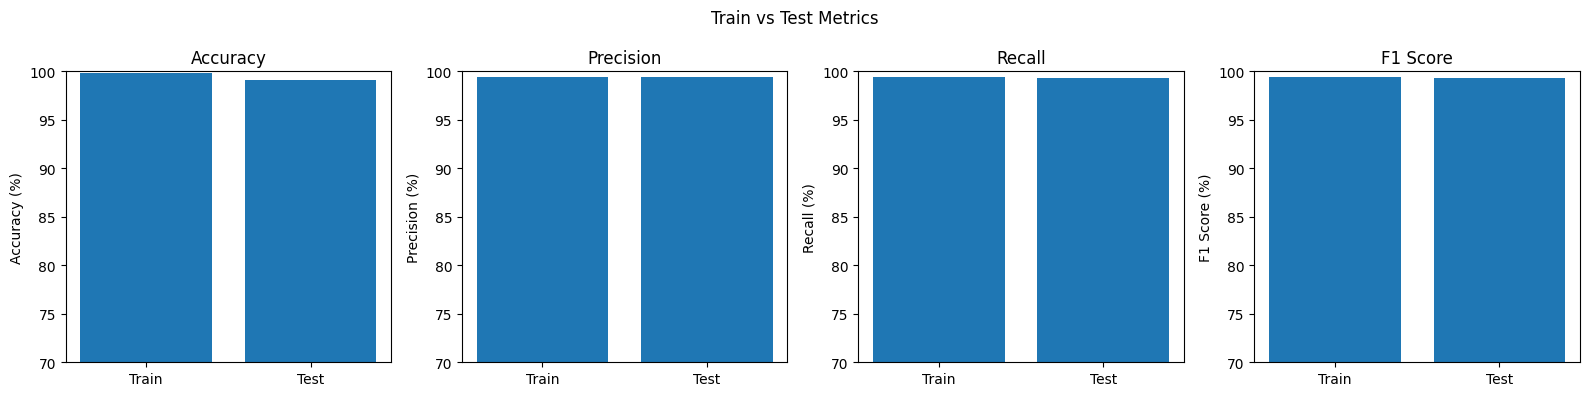

In [14]:
CNN_2D_val_precision = np.average(precision_val) * 100
CNN_2D_val_recall = np.average(recall_val) * 100
CNN_2D_val_f1 = np.average(f1_val) * 100

# Calculate metrics for test set
y_pred_test = np.argmax(CNN_2D_best_model.predict(X_2D_test), axis=1)
y_true_test = np.argmax(y_2D_test, axis=1)
CNN_2D_test_precision = precision_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_recall = recall_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_f1 = f1_score(y_true_test, y_pred_test, average='weighted') * 100

print('CNN 2D Validation Precision = {:.2f}%'.format(CNN_2D_val_precision))
print('CNN 2D Validation Recall = {:.2f}%'.format(CNN_2D_val_recall))
print('CNN 2D Validation F1 Score = {:.2f}%'.format(CNN_2D_val_f1))
print('CNN 2D Test Precision = {:.2f}%'.format(CNN_2D_test_precision))
print('CNN 2D Test Recall = {:.2f}%'.format(CNN_2D_test_recall))
print('CNN 2D Test F1 Score = {:.2f}%'.format(CNN_2D_test_f1))

# Plot train vs test metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Train vs Test Metrics')

ax1.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Train', 'Test'])
ax1.set_ylim([70, 100])

ax2.bar([1, 2], [CNN_2D_val_precision, CNN_2D_test_precision])
ax2.set_title('Precision')
ax2.set_ylabel('Precision (%)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Train', 'Test'])
ax2.set_ylim([70, 100])

ax3.bar([1, 2], [CNN_2D_val_recall, CNN_2D_test_recall])
ax3.set_title('Recall')
ax3.set_ylabel('Recall (%)')
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Train', 'Test'])
ax3.set_ylim([70, 100])

ax4.bar([1, 2], [CNN_2D_val_f1, CNN_2D_test_f1])
ax4.set_title('F1 Score')
ax4.set_ylabel('F1 Score (%)')
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Train', 'Test'])
ax4.set_ylim([70, 100])

plt.tight_layout()
plt.show()

## Notes

- **Running the Notebook**: Ensure the CWRU dataset files are in the 'CWRU_BearingData_Load_2HP' folder. Install required libraries (e.g., `pip install PyWavelets` for pywt).
- **Switching Input Types**: Change `image_type` to 'spectrogram' in the main execution cell to use spectrograms instead of scalograms.
- **Performance**: Per Verstraete et al., scalograms achieve up to 99.5% accuracy on CWRU data with 96x96 images, outperforming spectrograms (99.5%) and HHT (97.6%).
- **Scalability**: 96x96 images increase computational load. For lower memory usage, set `image_shape = (32, 32)`, but expect reduced accuracy (e.g., 98.8% for scalograms).

This notebook provides an interactive environment to experiment with time-frequency-based fault diagnosis, leveraging the strengths of CNNs for automatic feature learning.